# Forecasting sales of breakfast items in Apollo Hospitals using ARIMA models

## Introduction

This problem was given to me as part of an interview for a start-up based in Cambodia that creates Point of Sale (POS) software. The aim is to predict sales of breakfast items in an Apollo Hospital in India, in order to reduce expenditure and waste. My preferred model is a simple feed-forward neural network with embeddings (which is detailed in another notebook). However, it wasn't clear whether classical or modern machine learning techniques would be more accurate with such a small amount of data. 

In this notebook, I perform an Exploratory Data Analysis (EDA) and fit ARIMA models to the sales data, to provide useful baseline predictions to compare with the neural network. Much of the analysis was inspired by kernels and discussions from similar Kaggle competitions, including [Web Traffic Time Series Forecasting](https://www.kaggle.com/c/web-traffic-time-series-forecasting), [Recruit Restaurant Visitor Forecasting](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting), [Rosmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales) and [Corporación Favorita Grocery Sales Forecasting](https://www.kaggle.com/c/favorita-grocery-sales-forecasting), and the [Practical Time Series Analysis](https://www.coursera.org/learn/practical-time-series-analysis/home/welcome) course on Coursera. I use R, rather than Python, for the convenience of its auto.arima() function, which automatically selects ARIMA parameters.

## Preparations

Firstly, let's read in some libraries and the data provided.

### Load libraries and data files

In [27]:
library("astsa")
library("forecast")
library("repr")
library("ggplot2")
library("ggthemes")
library("gridExtra")
library("reshape2")
library("viridis")
library("Metrics")

In [3]:
df <- read.csv("data/IMB.csv", header=TRUE)
df$Date <- as.Date(df$Date, "%d/%m/%Y")

num_days <- nrow(df)
num_items <- length(df[-1:-2])

print(paste("Number of missing values: ", sum(is.na(df))))
print(paste("Dimensions of data: ", num_days, ncol(df)))
tail(df)

[1] "Number of missing values:  0"
[1] "Dimensions of data:  115 9"


,Date,Occupancy,Idly,Dosa,Chutney,Sambar,Continental.B.F,North.Indian.B.F,Omelette
110,2013-01-18,245,42,49,151,151,39,7,10
111,2013-01-19,198,61,15,127,127,40,3,18
112,2013-01-20,210,65,20,140,140,41,3,22
113,2013-01-21,200,61,14,129,136,41,6,22
114,2013-01-22,230,66,17,128,123,43,7,21
115,2013-01-23,233,44,16,139,139,44,4,17


The daily time series consists of sales data for 7 breakfast items, as well as the daily occupancy. The dataset is small, spanning 115 days (less than 4 months) from 1st October 2012 to 23rd January 2013. Luckily, there are no missing values.

### Load external datasets

As discussed below, it turns out that public holidays are important, so let's import the dates. The holiday data is drawn from [here](https://www.officeholidays.com/countries/india/tamil_nadu/index.php).

In [4]:
holidays <- read.csv("data/public_holidays_Tamil_Nadu.csv", header=TRUE)
holidays$Date <- as.Date(holidays$Date, "%d/%m/%Y"); holidays

Date,Holiday
2012-10-02,Mahatma Gandhi Birthday
2012-10-24,Dussehra
2012-10-26,Idul Juha
2012-11-13,Deewali
2012-11-28,Guru Nanak Birthday
2012-12-25,Christmas Day
2013-01-01,New Year’s Day
2013-01-14,Pongal
2013-01-15,Uzhavar Tirunal


## Feature visualisations

In this section, we'll perform an exploratory data analysis (EDA), using some custom plots to identify trends in the data.

### Occupancy

To start, let's look at the behaviour of occupancy. We'll mark holidays using vertical grey lines. Also, let's include a smoothed line to reduce some of the noise.

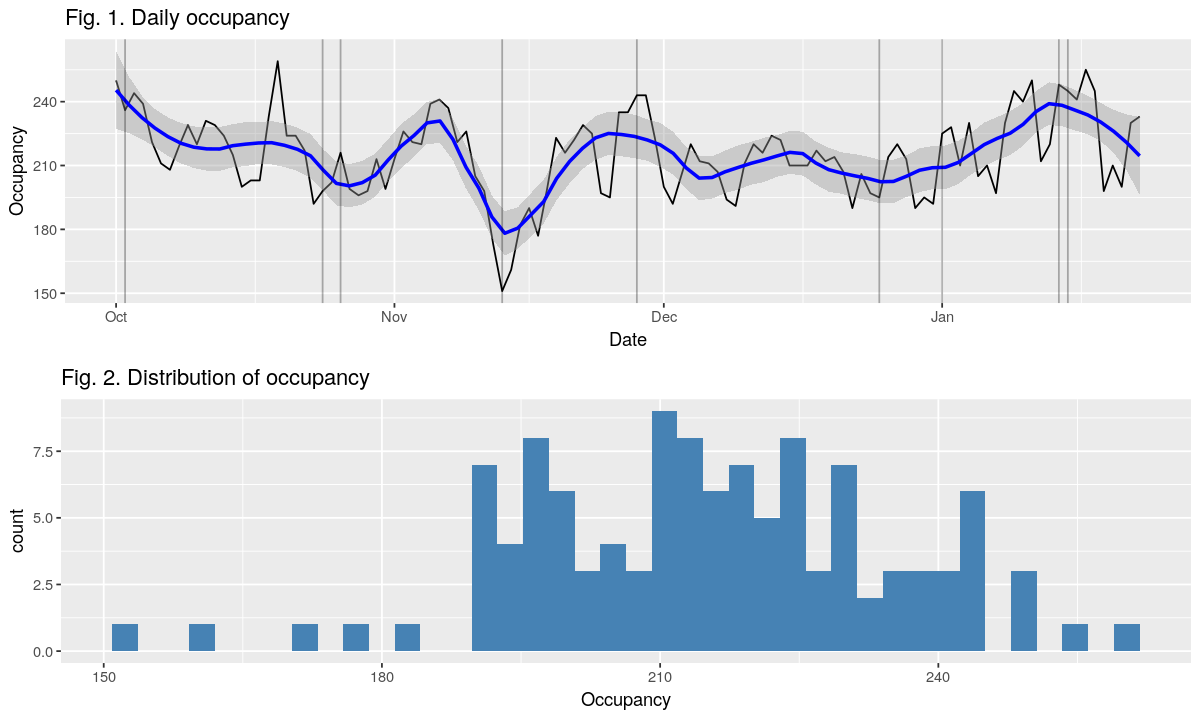

In [5]:
p1 <- ggplot(df, aes(Date, Occupancy)) +
    geom_line() +
    geom_smooth(method = "loess", color = "blue", span = 1/5) +
    geom_vline(data = holidays, aes(xintercept = as.Date(Date)), alpha = 0.3) +
    labs(x = "Date", y = "Occupancy", title = "Fig. 1. Daily occupancy") 

p2 <- ggplot(df, aes(Occupancy)) +
    geom_histogram(fill = "steelblue", bins = 40) +
    labs(x = "Occupancy", title = "Fig. 2. Distribution of occupancy")

options(repr.plot.width=10, repr.plot.height=6)
grid.arrange(p1, p2, nrow=2)

We notice that occupancy in the hospital is approximately constant over time, and not normally distributed, (probably owing to lack of data). It looks like some holidays might fall at maxima and minima in the time series. The drop in occupancy around the holiday in mid-November is particularly apparent. There are a large number of spikes in the time series plot, as well as the histogram, which will be difficult to predict without external data. Let's continue by investigating the relationship between occupancy and the day of the week.

In [6]:
df['DoW'] <- weekdays(df$Date)
df['Week'] <- strftime(df$Date, format = "%V")
df$DoW <- factor(df$DoW, levels= c("Monday","Tuesday","Wednesday","Thursday","Friday", 
                                                       "Saturday", "Sunday"))
df$Week <- factor(df$Week, levels= c(c("40":"52"),paste0("0",c("01":"04"))))

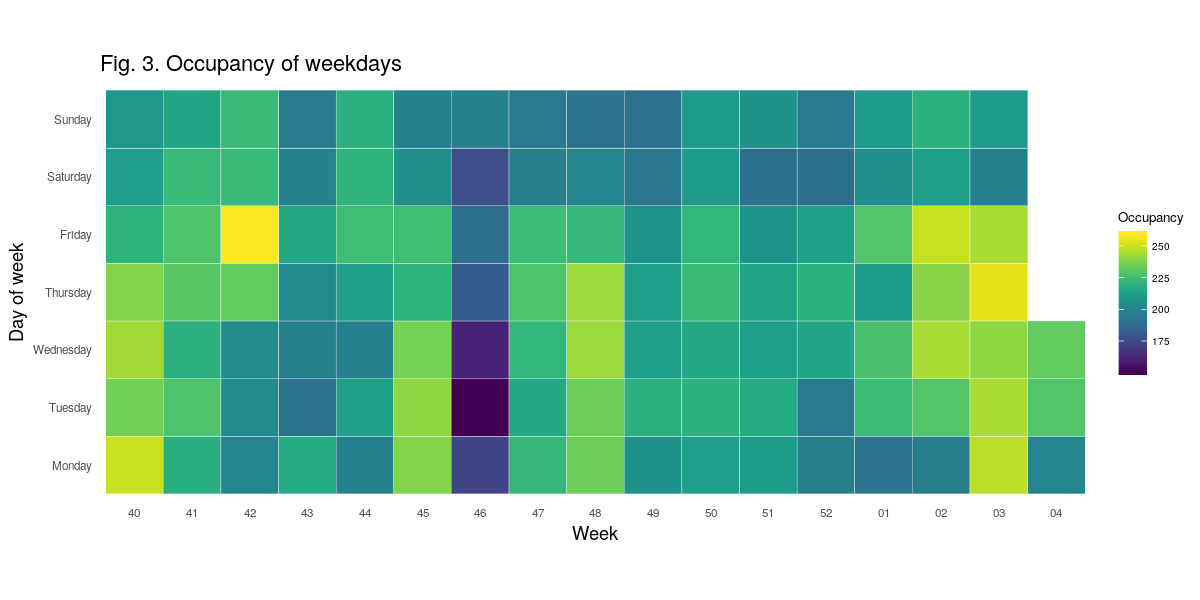

In [7]:
p3 <- ggplot(df, aes(Week, DoW, fill = Occupancy)) +
    geom_tile(color = "white", size=0.1) +
    scale_fill_viridis(name = "Occupancy") +
    coord_equal() +
    labs(x = "Week", y = "Day of week", title = "Fig. 3. Occupancy of weekdays") +
    theme_tufte(base_family = "Helvetica") +
    theme(plot.title=element_text(hjust=0)) +
    theme(axis.ticks = element_blank()) +
    theme(axis.text = element_text(size=7)) +
    theme(legend.title = element_text(size=8)) +
    theme(legend.text = element_text(size=6))

options(repr.plot.width=10, repr.plot.height=5); p3

Again, the lower occupancy around Diwali festival (week 46) is particularly apparent. It is interesting that occupancy is reduced despite the large crowds on the streets and higher levels of pollution that come with fireworks. There is a noticably higher occupancy in weeks 3 and 40. Week 3 contains Gandhi’s birthday, but this may be a coincidence since it is not clear why this would increase occupany. This week also falls in the new year after a busy festive period. We also notice that there is a lower occupancy on weekends. The next lowest occupancy occurs on Thursdays and Fridays, with the highest occurring Monday, Tuesday and Wednesday. This might be due to the fact that more people do not work on weekends (and may work less on Thursdays and Fridays).

### Sales of individual breakfast items

Now, let's look at the sales of individual breakfast items. 

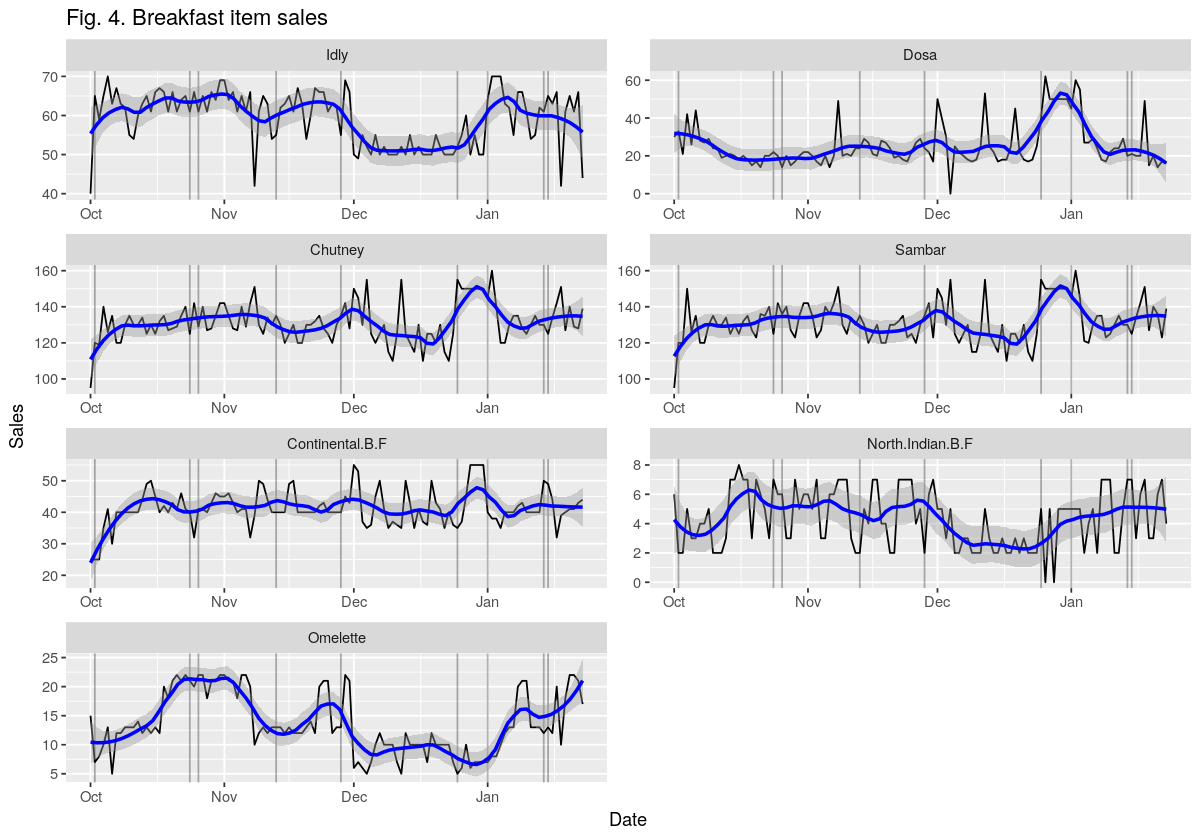

In [8]:
df$Total <- rowSums(df[,3:9])
df_items <- melt(df[c(1,3:9)], id="Date")

p4 <- ggplot(df_items, aes(Date,value)) + 
    geom_line() + 
    geom_vline(data = holidays, aes(xintercept = as.Date(Date)), alpha = 0.3) +
    geom_smooth(method = "loess", color = "blue", span = 1/5) +
    facet_wrap(~variable, nrow=4, scales = "free") + 
    labs(x = 'Date', y = 'Sales', title = "Fig. 4. Breakfast item sales")

options(repr.plot.width=10, repr.plot.height=7); p4

Some items are less popular than others. For example, the North Indian breakfast sales are low, perhaps since the hospital is in the [South India](https://en.wikipedia.org/wiki/Apollo_Hospitals). The price of certain items may also play a role, but this information is not included. Long-term step reductions are seen in the sales of some breakfast items (i.e. idly, North Indian breakfast and omellette), especially around the start of December. However, the occupancy does not drop in the same manner. This could correspond to a change in the ordering of ingredients, resulting in popular items selling out, for example. These sudden changes will be difficult to predict. Let's looks at the distributions of the breakfast item sales for some more information.

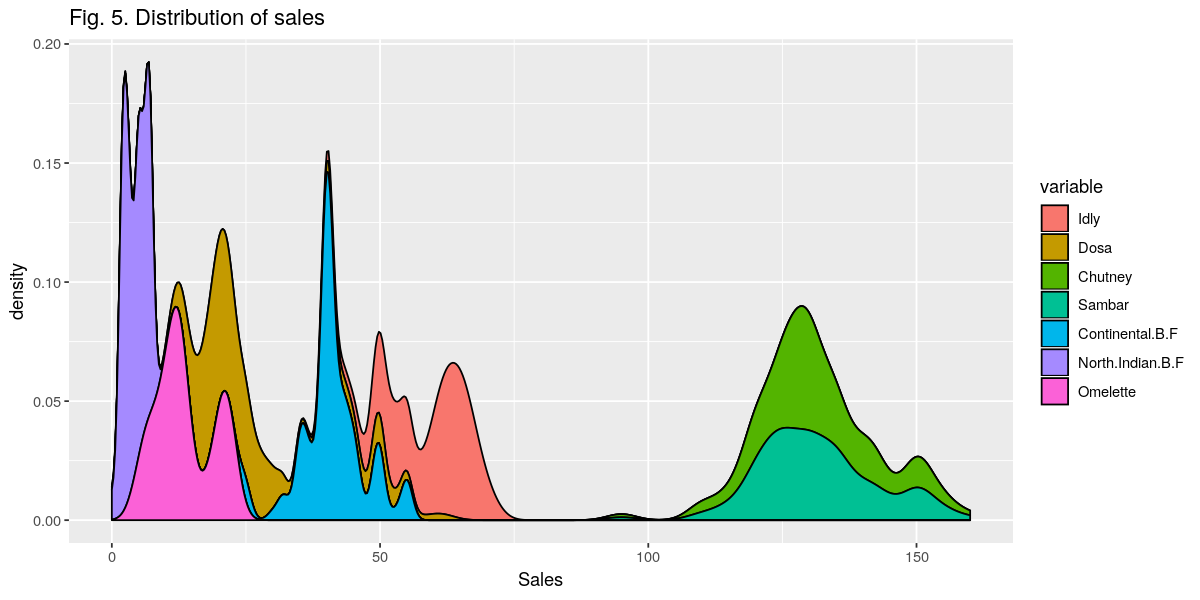

In [9]:
p5 <- ggplot(df_items, aes(value, fill=variable)) +
    geom_density(position = "stack") +
    labs(x='Sales', title="Fig. 5. Distribution of sales")

options(repr.plot.width=10, repr.plot.height=5); p5

Similar spikes in the distributions of different sales items seem to indicate that different modes of behaviour exist. For example, the distributions of chutney and sambar appear to be bimodal. The distribution of dosa shares certain modes of behaviour with both omelettes and continental breakfasts. This could be related to price or dietary plans, but further data would be needed to confirm this. Now, let's investigate the total sales of each item.

In [10]:
total_sales <- data.frame(Item=names(df[3:9]),Sales=colSums(df[,3:9]))
total_sales$Mean <- total_sales$Sales/num_days
total_sales$SD <- apply(df[,3:9], 2, sd)

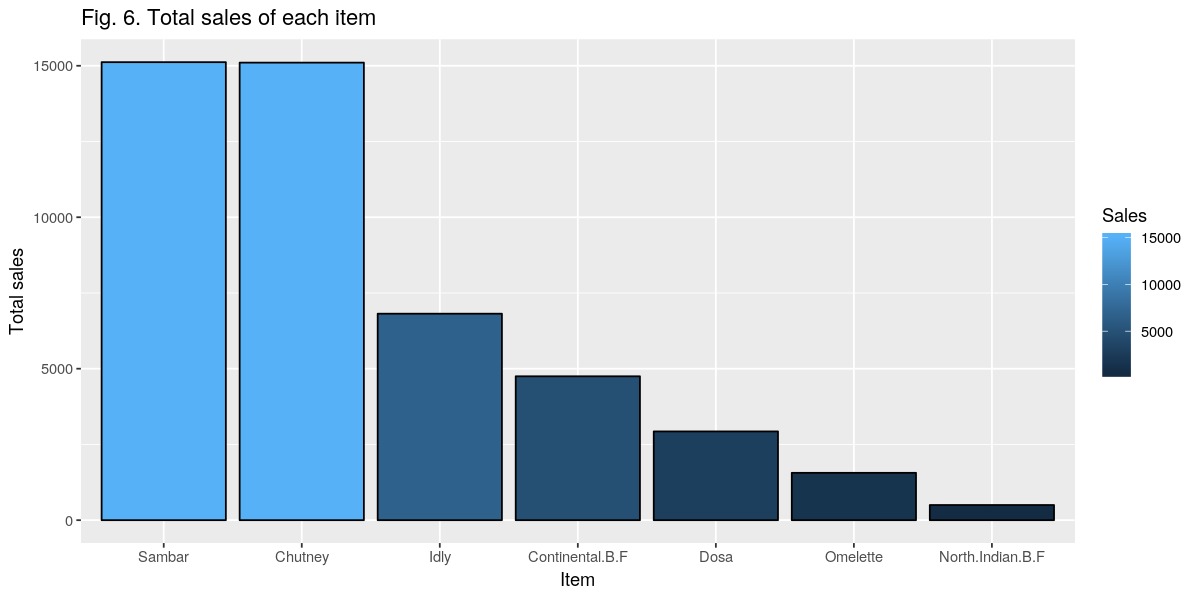

In [11]:
p6 <- ggplot(total_sales,aes(x=reorder(Item, -Sales), y=Sales, fill = Sales)) +
    geom_bar(colour="black", stat="identity") +
    labs(x='Item',y='Total sales', title="Fig. 6. Total sales of each item")

p6

In [12]:
print(paste("Correlation between sales of sambar and chutney: ", 
            cor(df$Sambar, df$Chutney)))

[1] "Correlation between sales of sambar and chutney:  0.981362501405995"


Since the sales and distributions are so similar, sambar and chutney must be typically sold as a pair. This is confirmed by the high correlation coefficient, *r*=0.98. The total sales of individual breakfast items differ by a factor of up to 30. Let's normalise the sales to further investigate similar behaviour.

### Normalised sales of breakfast items

In [13]:
norm_sales <- df[,c(1,3:9)]
norm_sales[,-1] <- sweep(norm_sales[,-1], 2, total_sales$Mean, FUN = "-")
norm_sales[,-1] <- sweep(norm_sales[,-1], 2, total_sales$SD, FUN = "/")

df_items_norm <- melt(norm_sales, id="Date")

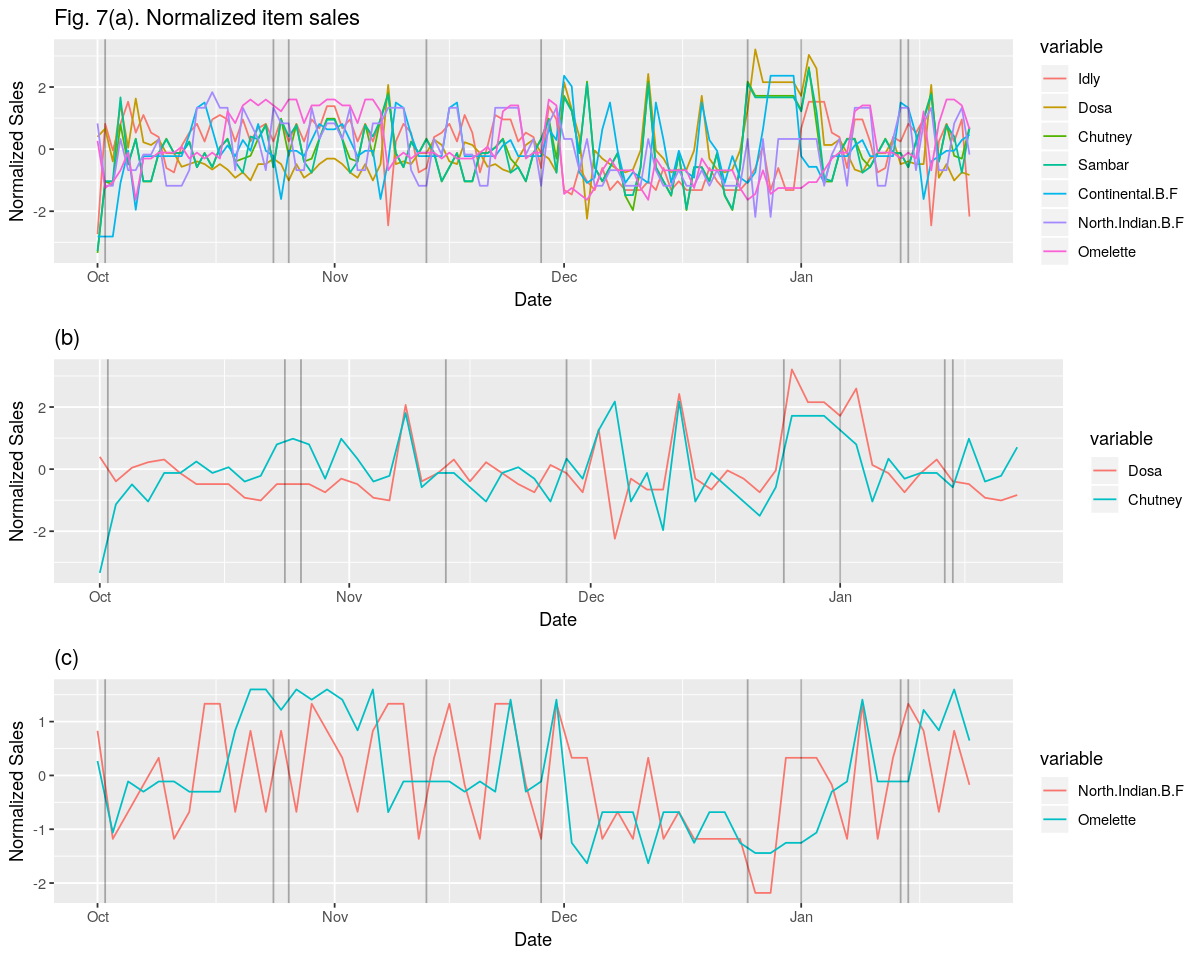

In [14]:
p7a <- ggplot(df_items_norm, aes(Date,value, colour=variable)) + 
    geom_line() + 
    geom_vline(data = holidays, aes(xintercept = as.Date(Date)), alpha = 0.3) +
    labs(x='Date', y='Normalized Sales', title="Fig. 7(a). Normalized item sales") 

p7b <- ggplot(df_items_norm[df_items_norm$variable==c("Chutney","Dosa"),], 
              aes(Date,value, colour=variable)) + 
    geom_line() + 
    geom_vline(data = holidays, aes(xintercept = as.Date(Date)), alpha = 0.3) +
    labs(x='Date', y='Normalized Sales', title="(b)") 

p7c <- ggplot(df_items_norm[df_items_norm$variable==c("Omelette","North.Indian.B.F"),], 
              aes(Date,value, colour=variable)) + 
    geom_line() + 
    geom_vline(data = holidays, aes(xintercept = as.Date(Date)), alpha = 0.3) +
    labs(x='Date', y='Normalized Sales', title="(c)") 

options(repr.plot.width=10, repr.plot.height=8)
grid.arrange(p7a, p7b, p7c, nrow=3)

As discovered above, chutney and sambar have very similar behaviour. Now we find that dosa behaves similarly also. Finally, omelette shows similar behaviour to North Indian breakfast. 

### Correlation between occupancy and sales

It is not trivial to include additional features in ARIMA models. Let's investigate whether this impacts our model, by investigating whether there is a correlation between occupancy and total sales.

[1] "Correlation between daily occupancy and sales:  -0.0110065115732887"


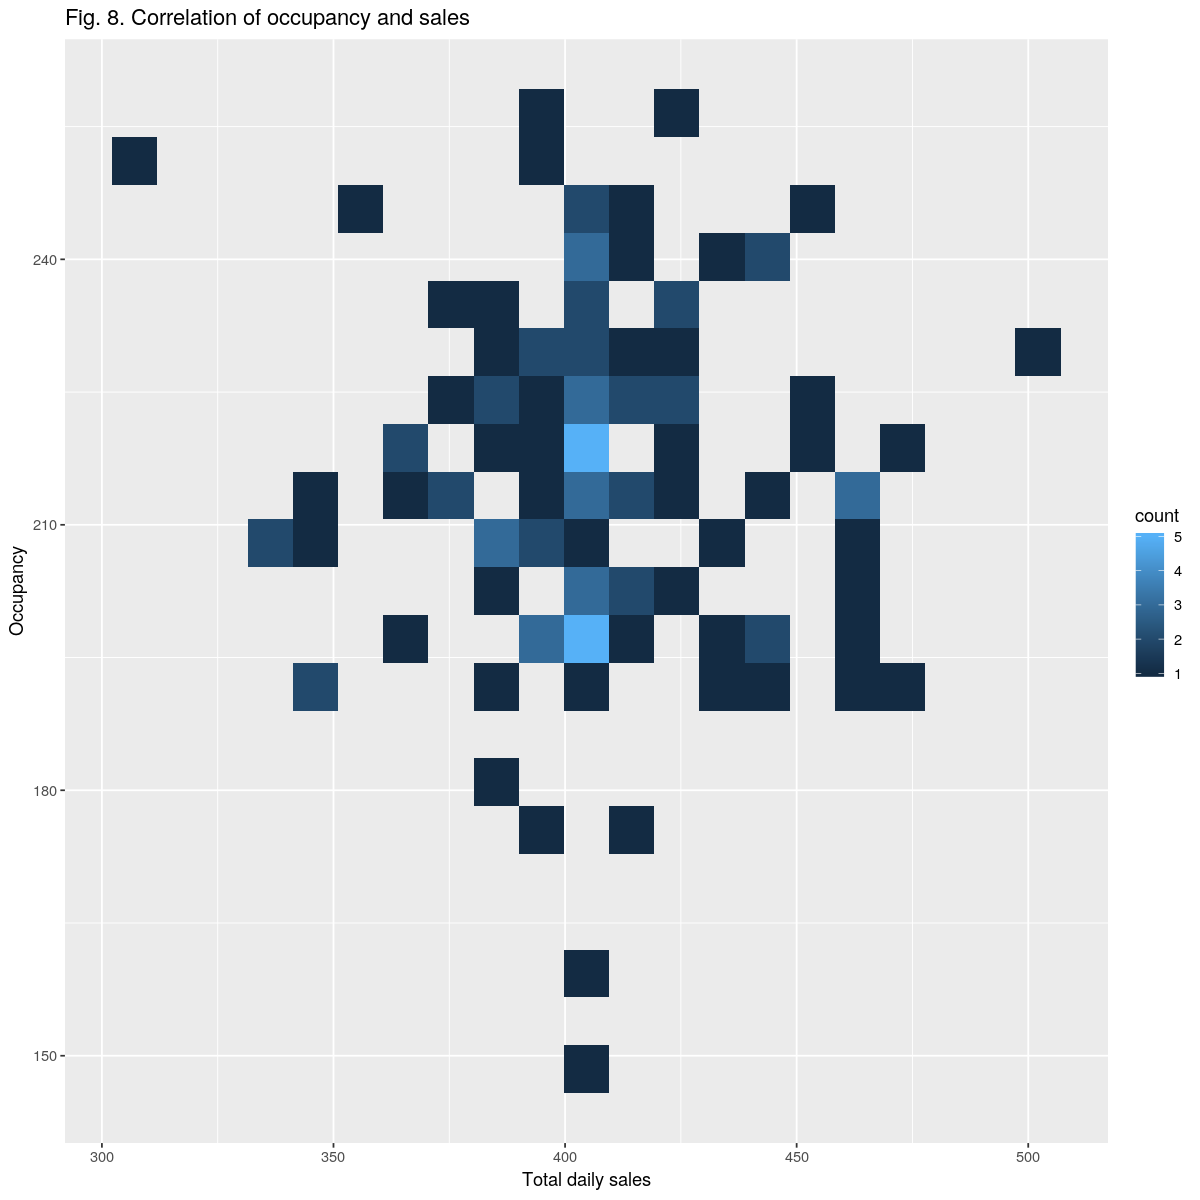

In [15]:
p8 <- ggplot(df,aes(Total, Occupancy)) +
    geom_bin2d(bins = c(20,20)) +
    labs(x = "Total daily sales", title="Fig. 8. Correlation of occupancy and sales")

print(paste("Correlation between daily occupancy and sales: ", 
            cor(df$Occupancy, df$Total)))
options(repr.plot.width=10, repr.plot.height=10); p8



No obvious trend is observed and the correlation coefficent is approximately 0. The correlations for individual item sales all fall below 0.2. The model is not suffering by not including occupancy as a feature.

## Forecasting using ARIMA models

In the previous section, we manually inspected the data to identify trends. In this section, we attempt to forecast future sales of breakfast items. Many real world processes can be modelled using ARIMA models, or a combination of: 

-  Autoregressive AR(*p*) terms, representing dependence on previous time steps.
-  Integrated I(*d*) terms, defining the number of difference operations that are performed with previous values of the time series, to ensure stationarity. For a time series to be stationary, it must have constant mean (i.e. no trend), and constant variance.
-  Moving average MA(*q*) terms, representing dependence on errors of previous time steps.

ARIMA models are parametric and require determination of the ARIMA parameters for each time series.

### Create training, validation and test sets

To match the neural network predictions, the aim is to forecast just one day into the future (neural networks commonly train separate models for forecasting successive days into the future). 

The validation set is used to select the parameters of the models. It is not randomly sampled, since this gives the model more information than it actually has in production. For example, filling in the gaps between dates is easier than forecasting into the future. Instead, a more representative validation set is selected that represents data that will be observed in the future in a realistic manner. A separate test set, with the same length as the validation set, is witheld until the very end. This ensures that we do not tune the model parameters so that they work better than expected, [by chance](http://www.fast.ai/2017/11/13/validation-sets/). 

In [16]:
train_size <- 113
test_size <- 1
val_size <- test_size

X_train <- df[1:train_size,-3:-9]
X_val <- df[(train_size+1):(train_size+val_size),-3:-9]
X_test <- df[(train_size+val_size+1):(train_size+val_size+test_size),-3:-9]

y_train <- df[1:train_size,3:9]
y_val <- df[(train_size+1):(train_size+val_size),3:9]
y_test <- df[(train_size+val_size+1):(train_size+val_size+test_size),3:9]

Importantly, it appears that the validation and test data largely avoid irregularities in the data, such as step changes or sudden spikes (see Fig. 4).

### Manual selection of parameters

To illustrate the use of different fitting tools, the parameters are manually fit for the first breakfast item. We begin by investigating the autocorrelation of the time series, using Ljung-Box Q-statistics:

In [17]:
Box.test(y_train$Idly, lag = log(length(y_train$Idly)))


	Box-Pierce test

data:  y_train$Idly
X-squared = 67.753, df = 4.7274, p-value = 2.028e-13


The p-value from the Ljung-Box test is much smaller than the typical 5% confidence interval, indicating that there is an autocorrelation between time lags that we can fit an ARIMA model to. From Fig. 4, we see the time series for sales of idly is not stationary. The trend in the data suggests that an order of differencing *d* is required. Let's apply a single differencing operation to the sales data.

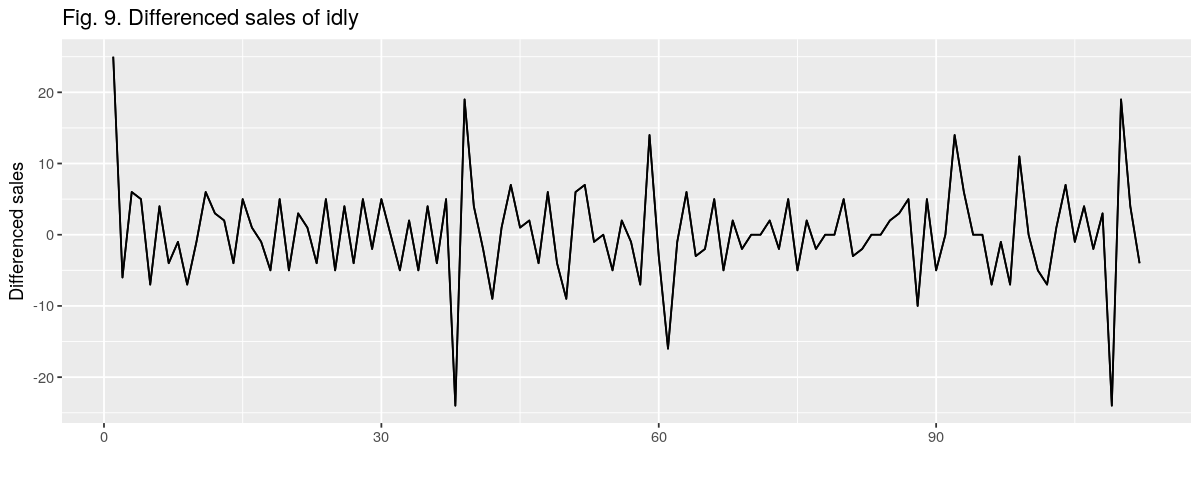

In [18]:
p9 <- qplot(seq_along(diff(y_train$Idly)),diff(y_train$Idly), geom = "path") +
    geom_line() +
    labs(x = "", y = "Differenced sales", title = "Fig. 9. Differenced sales of idly")

options(repr.plot.width=10, repr.plot.height=4)
p9

This looks like it might be stationary. There are a few spikes but let's attribute these to randomness.

In [19]:
Box.test(diff(y_train$Idly), lag = log(length(diff(y_train$Idly))))


	Box-Pierce test

data:  diff(y_train$Idly)
X-squared = 14.08, df = 4.7185, p-value = 0.01235


The Box test indicates THAT the p-value of THE differenced time series is still small, indicating that there is still some autocorrelation. The autocorrelation function (ACF) gives a measures of the correlation of the time series with lagged versions of itself. We inspect it to suggest the order *p* of the MA process.

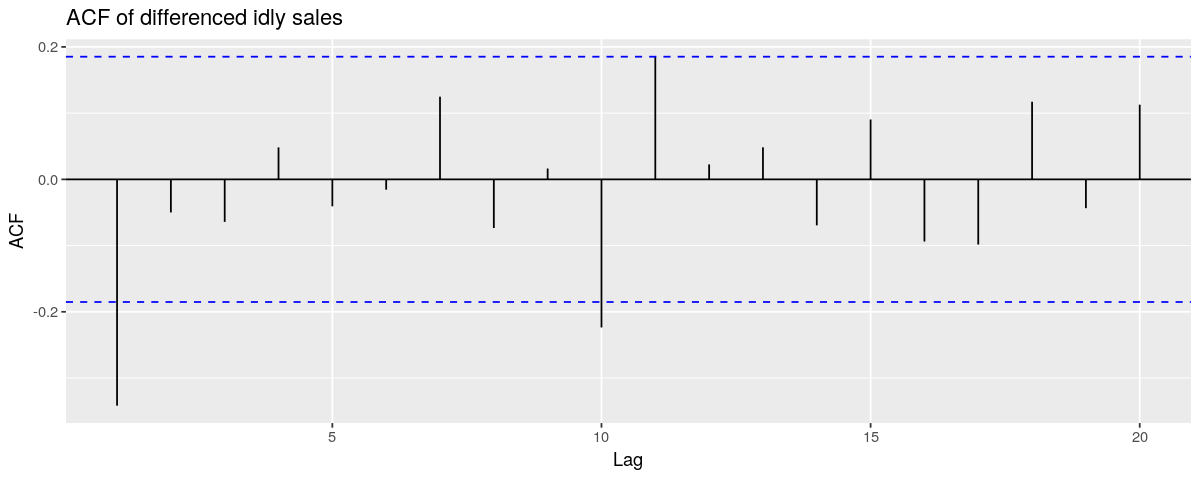

In [20]:
ggAcf(diff(y_train$Idly)) +
    labs( title = "ACF of differenced idly sales")

There is not a huge amount of correlation between visits on a certain day and on previous days, with the most significant autocorrelation at lag 1. While the value is also significant at lag 10, seasonal ARIMA models typically require at least 4 whole seasons of data. Hence, we'll ignore the spike and attribute it to randomness.

The partial autocorrelation function (PACF) is similar to the ACF, but measures the autocorrelation after removing effects previously explained at earlier lags. We inspect the plot to suggest the order *q* of the AR process.

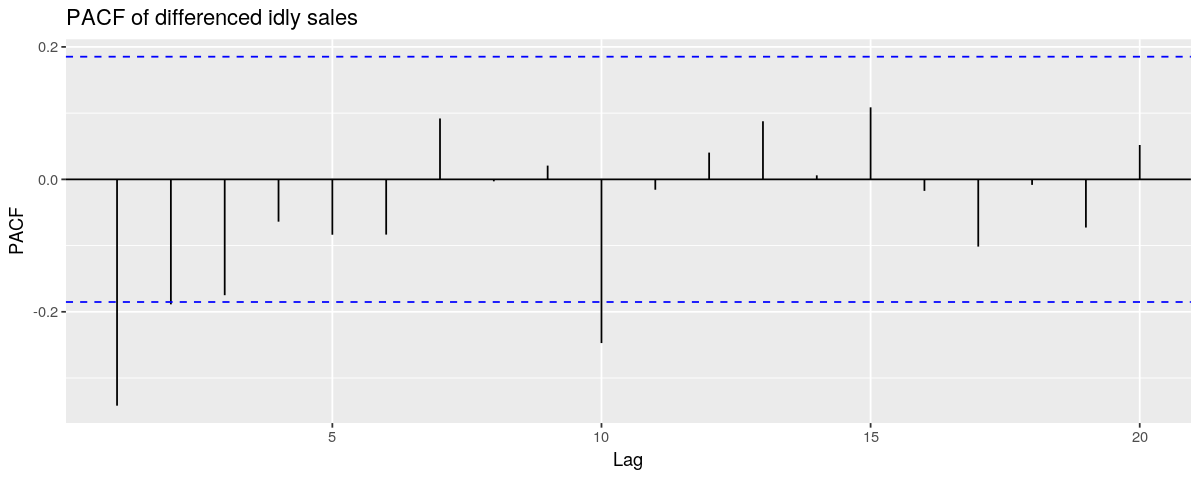

In [21]:
ggPacf(diff(y_train$Idly)) +
    labs( title = "PACF of differenced idly sales")

The lags at 1, 2 and 10 are all above the threshold, with lag 3 falling just below. For illustrative purposes, we fit an ARIMA model for the first three orders of both the MA and AR terms using brute force. We extract the sum of squared errors (SSE), and the Akaike Information Criterion (AIC), which essentially quantifies a trade off between the error and model simplicity. We also extract the residuals, and hope that there remains no autocorrelation between lags. 

In [22]:
SSE=array(numeric(),9) 
AIC=array(numeric(),9) 
pval=array(numeric(),9) 
rownames=array(character(),9) 

for (i in 0:2) { 
    for (j in 0:2) {
        m <- arima(y_train$Idly, order=c(i,1,j), include.mean=FALSE)
    
        SSE[(i+1)+3*j] <- sum(m$residuals^2)
        AIC[(i+1)+3*j] = m$aic

        m.test <- Box.test(m$residuals, lag = log(length(m$residuals)))
        pval[(i+1)+3*j] <- m.test$p.value
        
        rownames[(i+1)+3*j] <- paste(c("ARIMA(", i, ",1,", j, ")"), collapse = "")
  }
}

data.frame(row.names = rownames,AIC,SSE,pval)

,AIC,SSE,pval
"ARIMA(0,1,0)",748.3235,5137.002,0.01153587
"ARIMA(1,1,0)",734.4760,4452.796,0.14933686
"ARIMA(2,1,0)",731.4941,4255.442,0.34170767
"ARIMA(0,1,1)",720.8073,3922.493,0.60985787
"ARIMA(1,1,1)",720.7140,3848.271,0.92722603
"ARIMA(2,1,1)",722.7077,3848.050,0.93074610
"ARIMA(0,1,2)",720.8941,3854.674,0.89949119
"ARIMA(1,1,2)",722.7107,3848.163,0.92901218
"ARIMA(2,1,2)",724.5779,3843.502,0.93947629


The p-values of all but the first model indicate that the residuals do not have significant autocorrelation. The lowest AIC value is found for the ARIMA(1,1,1) model. The ARIMA(2,1,1) has slightly lower SSE, but the additional complexity is not worth the improvement of accuracy. 

### Forecasting future sales

Now we can forecast the sales of idly. We can also plot the confidence interval, which is an advantage of the current technique over the neural network model. 

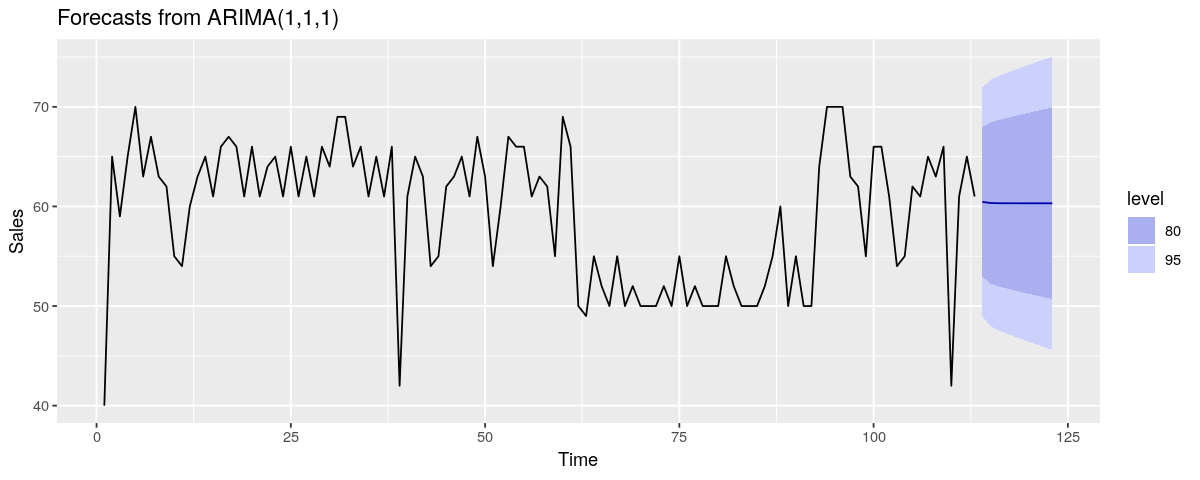

In [23]:
m <- arima(y_train$Idly, order=c(1,1,1), include.mean=FALSE)
fc <- forecast(m)
y_pred <- fc$mean[1]

autoplot(fc) +
    labs(y = "Sales")

We see that the forecast is approximately linear with a constant value. Let's look at the error of the prediction.

In [24]:
print(paste("Mean absolute error (MAE) of validation set is: ",
            mae(round(fc$mean[1]), y_val$Idly)))

[1] "Mean absolute error (MAE) of validation set is:  6"


We have predicted 60 sales of idly on 22nd January, while 66 dishes are actually sold. 

### Automatic selection of parameters

For convenience, the auto.arima function is used for the remaining breakfast items, which is accurate enough for our needs (providing a useful baseline to compare with the neural network later). The automatic function uses a complex grid search and sophisticated algorithm behind the scenes. We extract the selected values of *p, d* and *q,* and predict the sales (rounded to the nearest integer) and calculate the MAE for each breakfast item. 

In [25]:
ypred <- array(numeric(),num_items) 
MAE <- array(numeric(),num_items) 
orders <- array(numeric(),c(num_items,3)) 

for (i in 1:num_items) {
    fit <- auto.arima(y_train[,i], d=1, stepwise = FALSE, approximation = FALSE)
    orders[i,] <- arimaorder(fit)
    fc <- forecast(fit)
    y_pred[i] <- round(fc$mean[1])
    MAE[i] <- mae(y_pred[i], y_val[,i])
}

data.frame(Actual=unlist(y_val),Predictions=y_pred,MAE)

,Actual,Predictions,MAE
Idly,66,60,6
Dosa,17,19,2
Chutney,128,131,3
Sambar,123,134,11
Continental.B.F,43,41,2
North.Indian.B.F,7,5,2
Omelette,21,20,1


The maximum absolute error of the forecasts is 11 (for sambar), which is pretty good considering the small amount of noisy input data. Now let's look at the orders that the automatic function chose.

In [26]:
colnames(orders) <- c("p","d","q")
data.frame(orders, row.names = colnames(y_val))

,p,d,q
Idly,0,1,1
Dosa,1,1,1
Chutney,1,1,1
Sambar,1,1,1
Continental.B.F,2,1,1
North.Indian.B.F,1,1,1
Omelette,1,1,1


As we see, the automatic function chooses different parameters for idly sales. This is likely because the auto.arima() function sets an infinite value for the AIC of the model if the AR polynomial is approximately non-stationary, or the MA polynomial is approximately non-invertible. The ARIMA(1,1,1) model works pretty well for all breakfast items. 

## Conclusion

In this notebook, ARIMA models have been fit to the sales of 7 breakfast items, and used to forecast future sales. Since the goal is to reduce food wastage, the hospital may need a week or more to buy ingredients. This is possible with the current model. In future, it would be interesting to explore the effects of other features, such as the weather or dietary plans of patients. 

It is easy to see how this problem applies to POS software for retailers. With smart algorithms that anticipate sales in a shop, promotions can be tailored for certain days and selling out of items can be avoided. The next notebook will investigate the performance of a simply feed-forward neural network with entity embedding. 